# translating matlab code parser

## setup

In [23]:
from pathlib import Path
import numpy as np
import pandas as pd
import time

from itertools import groupby
from collections import Counter
from operator import itemgetter

from tqdm import tqdm_notebook, tnrange

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid',rc={'figure.facecolor':'#abb2bf'})

## params

In [2]:
# paths
#lvm_path = Path(r'data/qim_20kbps_10db_l2_v2.lvm')
lvm_path = Path(r'data/test_packet.txt')

# signal specific params
spb = 20

## class building

In [140]:
class DataParserLVM:
    def __init__(self, lvm_path, source='txt', header=None, preprocess_mode='static'):
        print('initializing..')
        
        # set input path
        if isinstance(lvm_path, Path):
            try: 
                assert lvm_path.exists()
                self.lvm_path = lvm_path
                print(f'\tset input lvm path: {self.lvm_path}')
            except AssertionError:
                print(f'no file found at {lvm_path}')
                raise                
        else:
            print(f'invalid path {lvm_path}, must be pathlib.Path object')
            raise TypeError
                
        # header
        if header is None:
            #self.header = np.array([1 if i % 2 == 0 else 0 for i in range(30)])
            self.header = np.ones(50, dtype=int)
            print(f'\tset header: {self.header}')
        else:
            if isinstance(header, list):
                self.header = np.array(header)
                print(f'\tset header: {self.header}')
            elif isinstance(header, np.ndarray):
                self.header = header
                print(f'\tset header: {self.header}')
            else:
                print(
                    f'invalid header format specified ({type(header)}), ' + 
                    f'must be np.array or list'
                )
                raise TypeError
        
        # source
        if source == 'txt':
            self.parse_other_file()
        elif source == 'lvm':
            self.parse_lvm_file()
            self.read_csv_data()
        else:
            print(
                f'invalid source {source}, options are ' + 
                '\'txt\' for tab delimited numbers only or ' + 
                '\'lvm\' for lvm file with headers'
            )
            
        # data message
        self.data_msg = self.create_data_message()
        print(f'created data message, {self.data_msg.size} bits')
        
        # startup tasks
        self.preprocess_data(mode=preprocess_mode)
        
    #------------------------------ ingestion and processing ------------------------------
    def create_data_message(self):
        scaler = 1
        base = np.array([1 if i % 2 == 0 else 0 for i in range(20)])
        
        return np.concatenate((
            np.repeat(base, scaler), 
            np.repeat(base, scaler), 
            np.repeat(base, 2*scaler), 
            np.repeat(base, scaler), 
            np.repeat(base, scaler), 
            np.repeat(base, 2*scaler)
        ))
        
        
    def parse_other_file(self):
        print('parsing tab delimited file..')
        self.raw_data = np.genfromtxt(
            self.lvm_path,
            delimiter='\t',
            usecols=(1)
        )        
        print(f'\timported data, {self.raw_data.size} rows')
        
            
    def parse_lvm_file(self, output_path='auto'):
        """
        reads in .lvm file, writes out .csv with column names
        containing only data points
        
        [arguments]
        input_path: str or pathlib.Path object (preferred)
            input file path
        output_path: 'auto' (preferred) or str or pathlib.Path object
            if auto:
                appends _parsed.csv to end of input file name
            else:
                use provided path, must end in .csv
                
        [returns]
        None
            outputs parsed lvm file
            sets self.parsed_lvm_path, pathlib.Path object pointing to parsed file
        """
        
        print('parsing lvm file..')
        with open(self.lvm_path, 'r') as infile:
            # set output path
            file_name = infile.name
            
            if output_path == 'auto':
                self.parsed_lvm_path = Path(f'{file_name}_parsed.csv')
            else:
                self.parsed_lvm_path = output_path
                
                if isinstance(parsed_lvm_path, Path):
                    try:
                        assert str(parsed_lvm_path).endswith('.csv')
                    except AssertionError:
                        print('output file must end with .csv')
                        raise
                elif isinstance(parsed_lvm_path, str):
                    try:
                        assert parsed_lvm_path.endswith('.csv')
                    except AssertionError:
                        print('output file must end with .csv')
                        raise
                else:
                    print('error, output_path must be str or pathlib.Path object')
                    raise TypeError
            
            if not self.parsed_lvm_path.exists():
                self.parsed_lvm_path.touch()
            
            # find header, store column names
            while True:
                line = infile.readline()
                
                if line.strip().endswith('Comment'):
                    cols = line.split(',')[:-1]
                    print(f'\tcolumns: {cols}')
                    break        
                    
            # trim file and write out
            with open(self.parsed_lvm_path, 'w') as outfile:
                outfile.write(', '.join(cols) + '\n')
                while True:
                    try:
                        outfile.write(next(infile))
                    except StopIteration:
                        break
        
        print(f'\tcomplete, parsed file saved to: {self.parsed_lvm_path}')
        
    def read_csv_data(self):
        print('importing data from parsed csv..')
        self.raw_data = np.genfromtxt(
            self.parsed_lvm_path,
            delimiter=',',
            skip_header=1,
            usecols=(1)
        )
        
        print(f'\timported data, {self.raw_data.size} rows')
        
        
    def preprocess_data(self, mode='static'):
        """
        convert float data into 1's and 0's
        
        static: use 1/2 * max data point as threshold
        dynamic: use min + 1/2(max - min) as threshold
        """
        
        if mode == 'static':
            th = self.raw_data.max() / 2
        elif mode == 'dynamic':
            th = self.raw_data.min() + (self.raw_data.max() - self.raw_data.min()) / 2
        else:
            print(f'invalid mode {mode}, options are \'static\' or \'dynamic\'')        
        
        shape_check = self.raw_data[np.where(self.raw_data >= th)].size
        
        self.raw_data[np.where(self.raw_data >= th)] = 1
        self.raw_data[np.where(self.raw_data < th)] = 0
        
        # set dtype and store
        self.data = self.raw_data.astype('int')[7:]
        
        # validate
        try:
            assert self.data.sum() == shape_check            
        except AssertionError:
            print(
                f'error: sum of 1\'s ({self.data.sum()}) does not match ' + 
                f'number of entries >= th ({shape_check})'
            )
        
    #---------------------------------- discretization methods ----------------------------------    
    def get_state_length_list(self, data):
        '''
        takes data list ([1,1,0,1,0,0,...]) and returns numpy array 
        of duration of consecutive bits ([13,245,2588,19,1056,...])
        '''
        
        return np.diff(
            np.where(
                np.concatenate(
                    ([data[0]],
                     data[:-1] != data[1:],
                     [0]
                    )
                )
            )[0]
        )[::2]
    
    def get_correct_state_length_list(self, data):
        '''
        gets state lengths like above, but correctly..
        '''
        
        groups = groupby(data)
        
        return [sum(1 for _ in group) for _, group in groups]
    

    def discretize_signal(self, spb=12):
        start_time = time.time()
        print('discretizing signal..')
        
        # set params
        self.spb = spb
        
        discretized_data = []
        start_bit = self.data[0]
        alt_bit = 0 if start_bit == 1 else 1
        print(f'\tstarting bit: {start_bit}, alt bit: {alt_bit}')
        
        # get state lengths
        #state_lengths = self.get_state_length_list(self.data)
        state_lengths = self.get_correct_state_length_list(self.data)
        
        for i, state in enumerate(state_lengths):
            discretized_state = int(np.round(state / self.spb))
            #print(f'iter: {i}, discretized state: {discretized_state}')
            
            if i % 2 == 0:
                discretized_data.append([start_bit for j in range(discretized_state)])
            elif i % 2 == 1:
                discretized_data.append([alt_bit for j in range(discretized_state)])
            else:
                print('ya done messed up.')
        
        self.discretized_array = np.array([
            item for sublist 
                in discretized_data 
            for item in sublist
        ])
        
        reduction = 100 * (self.discretized_array.size / self.data.size)
        print(
            f'\tcomplete, discretized signal: {self.discretized_array.size} entries ' + 
            f'({reduction:0.2f}% of original)\n'
            f'\tprocessing time: {time.time() - start_time:0.4f} sec'
        )
        
    #---------------------------------- search and ber ----------------------------------
    def search_sequence_numpy(self, arr, seq):
        """ 
        find sequence in an array 
    
        Parameters
        ----------    
        arr    : input 1D array
        seq    : input 1D array
    
        Output
        ------    
        Output : array of starting indices of matches
        """
        
        # validate inputs
        try:
            assert isinstance(arr, np.ndarray)
        except AssertionError:
            print(f'input arr must be numpy array, you provided {type(arr)}')
            raise
            
        try:
            assert isinstance(seq, np.ndarray)
        except AssertionError:
            print(f'input seq must be numpy array, you provided {type(arr)}')
            raise
    
        # Store sizes of input array and sequence
        Na, Nseq = arr.size, seq.size
    
        # Range of sequence
        r_seq = np.arange(Nseq)
    
        # Create a 2D array of sliding indices across the entire length of input array.
        # Match up with the input sequence & get the matching starting indices.
        M = (arr[np.arange(Na-Nseq+1)[:, None] + r_seq] == seq).all(1)
    
        # Get the range of those indices as final output
        if M.any() > 0:
            tmp_array =  np.where(
                np.convolve(
                    M,
                    np.ones((Nseq), dtype=int)
                ) > 0
            )[0]
        else:
            tmp_array =  []
        
        
        match_starting_idxs = [
            list(map(itemgetter(1), g))[0]
            for k, g in groupby(enumerate(tmp_array), lambda ix: ix[0] - ix[1])
        ]
        
        print(f'found {len(match_starting_idxs)} matches')
        
        return match_starting_idxs
        
        
    def get_signal_stats(self, data):
        state_lengths = self.get_correct_state_length_list(data)
        
        return Counter(state_lengths).most_common()
    
    
    def compute_bit_error_rate(self):
        # find headers
        header_starts = self.search_sequence_numpy(self.discretized_array, self.header)
        print(f'found {len(header_starts)} headers')
        
        # slice data packets
        self.ber = []
        clipped_packets = 0
        
        for header in header_starts:
            start = header + len(self.header) + 4
            stop = start + len(self.data_msg)
            
            if self.discretized_array[start:stop].size == 160:
                data_slice = self.discretized_array[start:stop]
                self.ber.append((data_slice - self.data_msg).sum())
            else:
                clipped_packets += 1
                
        print(f'complete, found {clipped_packets} clipped packet(s)')
        print(
            f'bit error breakdown:\n' + 
            f'\ttotal messages computed: {len(self.ber)}\n' + 
            f'\tcumulative bit errors: {sum(self.ber)}\n' + 
            f'\tmean bit errors: {sum(self.ber) / len(self.ber)}\n' + 
            f'\tprobably all zero, if not all bit errors are stored in self.ber'
        )
        
        
    #---------------------------------- output methods ----------------------------------
    def output_discretized_array(self, output_path='auto', output_format='csv'):
        # set output path
        if output_path == 'auto':
            output_path = Path(r'data/discretized_array.csv')            
        elif isinstance(output_path, Path):
            try:
                assert output_path.parent.exists()
                assert output_path.name.endswith('.csv')
            except AssertionError:
                print(
                    f'parent path ({output_path.parent}) unavailable or ' + 
                    f'path does not end with .csv ({output_path.name}), ' + 
                    f'please choose another path'
                )
                raise
        elif isinstance(output_path, str):
            try:
                output_path = Path(output_path)
                assert output_path.parent.exists()
                assert output_path.name.endswith('.csv')
            except AssertionError:
                print(
                    f'parent path ({output_path.parent}) unavailable or ' + 
                    f'path does not end with .csv ({output_path.name}), ' + 
                    f'please choose another path'
                )
                raise
        else:
            print(
                f'you really messed up, you provided {output_path} {type(output_path)}, ' + 
                f'please provide output_path as str or pathlib.Path object ending with .csv'
            )            
        print(f'set discretized signal output path: {output_path}')
                
        # output
        if output_format == 'csv':
            np.savetxt(
                output_path,
                self.discretized_array,
                delimiter=','
            )
            print(f'\tsuccessfully saved file to: {output_path}')
        else:
            print(f'yeah.. csv is actually the only option.. please try again.')
            raise TypeError
            
    
    #---------------------------------- plotting methods ----------------------------------
    
    def plot_subset(self, data, start, stop):
        plt.figure(figsize=(20, 6))
        
        plt.stem(data[start:stop])
    
    def compare_plots(self, start, stop, title=None):
        if title is None:
            title='no title provided'
        
        fig, ((ax1, ax2)) = plt.subplots(2, 1, sharex=False, sharey=True, figsize=(15,6))
        
        ax1.stem(DP.data[start*DP.spb:stop*DP.spb])
        ax2.stem(DP.discretized_array[start:stop]) 
        
        ax1.set_title(title)
    
        
        
        

In [141]:
DP = DataParserLVM(
    lvm_path, 
    source='txt',
    preprocess_mode='dynamic'
)

initializing..
	set input lvm path: data\test_packet.txt
	set header: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
parsing tab delimited file..
	imported data, 3500000 rows
created data message, 160 bits


In [142]:
DP.discretize_signal(spb=12)

discretizing signal..
	starting bit: 1, alt bit: 0
	complete, discretized signal: 291668 entries (8.33% of original)
	processing time: 1.5962 sec


In [143]:
DP.compute_bit_error_rate()

found 1363 matches
found 1363 headers
complete, found 1 clipped packet(s)
bit error breakdown:
	total messages computed: 1362
	cumulative bit errors: 0
	mean bit errors: 0.0
	probably all zero, if not all bit errors are stored in self.ber


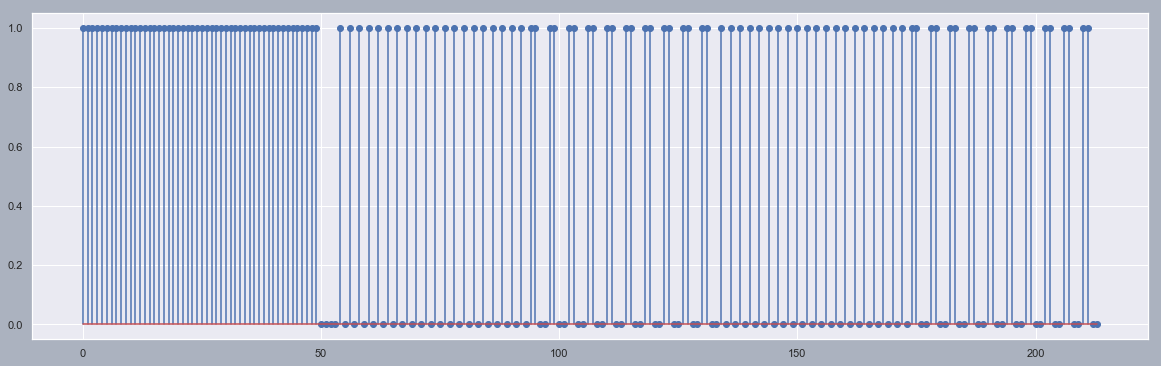

In [95]:
DP.plot_subset(
    DP.discretized_array, 
    start=header_matches[0], 
    stop=header_matches[0] + len(DP.header) + len(DP.data_msg) + 4
)

In [45]:
DP.header

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0])

In [43]:
DP.data_msg

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0])

## ber dev

In [138]:
def compute_bit_error_rate():
    # find headers
    header_starts = DP.search_sequence_numpy(DP.discretized_array, DP.header)
    print(f'found {len(header_starts)} headers')
    
    # slice data packets
    ber = []
    clipped_packets = 0
    
    for header in header_starts:
        start = header + len(DP.header) + 4
        stop = start + len(DP.data_msg)
        
        if DP.discretized_array[start:stop].size == 160:
            data_slice = DP.discretized_array[start:stop]
            ber.append((data_slice - DP.data_msg).sum())
        else:
            clipped_packets += 1
            
    print(f'complete, found {clipped_packets} clipped packet(s)')
    print(
        f'bit error breakdown:\n' + 
        f'\ttotal messages computed: {len(ber)}\n' + 
        f'\tcumulative bit errors: {sum(ber)}\n' + 
        f'\tmean bit errors: {sum(ber) / len(ber)}\n' + 
        f'\tprobably all zero, if not all bit errors are stored in self.ber'
    )

In [139]:
compute_bit_error_rate()

found 1363 matches
found 1363 headers
complete, found 1 clipped packet(s)
bit error breakdown:
	total messages computed: 1362
	cumulative bit errors: 0
	mean bit errors: 0.0
	probably all zero, if not all bit errors are stored in self.ber


In [97]:
header_starts = DP.search_sequence_numpy(DP.discretized_array, DP.header)
header_starts[:10]

found 1363 matches


[46, 260, 474, 688, 902, 1116, 1330, 1544, 1758, 1972]

### slicing

In [136]:
ber = []

for header in header_starts:
    start = header + len(DP.header) + 4
    stop = start + len(DP.data_msg)
    
    if DP.discretized_array[start:stop].size == 160:
        data_slice = DP.discretized_array[start:stop]
        ber.append((data_slice - DP.data_msg).sum())

In [137]:
sum(ber)

0

In [133]:
data_slice

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0])

In [135]:
(data_slice - DP.data_msg).sum()

0

In [110]:
start = header + len(DP.header) + 4
stop = start + len(DP.data_msg)
print(f'set slice: {start}:{stop}')

set slice: 100:260


In [111]:
DP.discretized_array[start:stop]

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0])

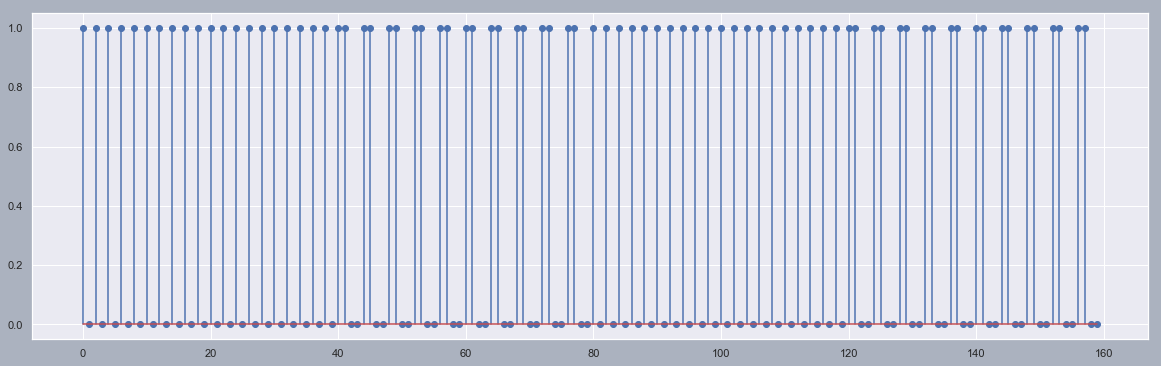

In [112]:
DP.plot_subset(DP.discretized_array, start, stop)

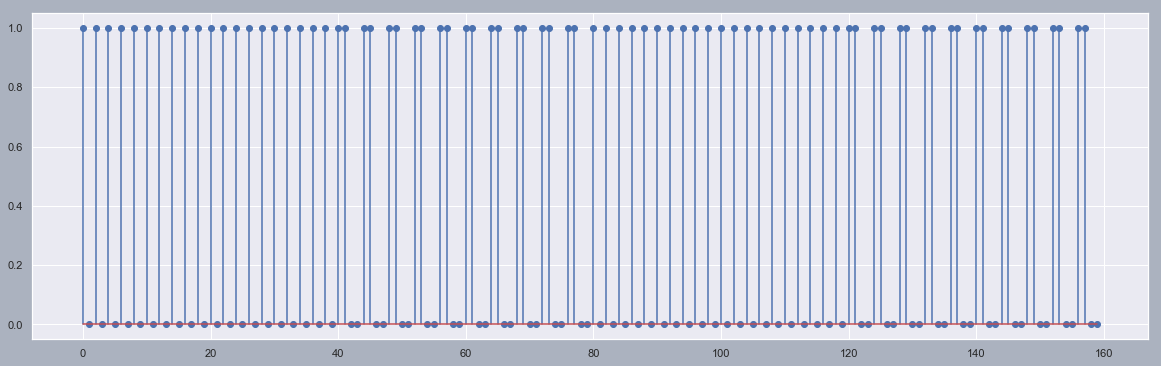

In [116]:
DP.plot_subset(DP.discretized_array, 100, 260)

## spb explorating <-- hilarious.

### frequency comparison

In [ ]:
def create_dataframe(original, discretized, spb):
    return (
        pd.concat(
            [
                (
                    pd
                    .DataFrame(
                        DP.get_signal_stats(original), 
                        columns=['length','frequency']
                    )
                    .assign(source='original')
                ),
                (
                    pd
                    .DataFrame(
                        DP.get_signal_stats(discretized), 
                        columns=['length','frequency']
                    )
                    .assign(source='discretized')
                )
            ]
        )
        .reset_index(drop=True)
        .assign(spb = spb)
    )

In [ ]:
spb_list = [i for i in range(5, 13, 1)]
df_dict = {}

for spb in spb_list:
    DP.discretize_signal(spb)
    
    df_dict[spb] = create_dataframe(DP.data, DP.discretized_array, DP.spb)

In [ ]:
full_df = (
    pd
    .concat([df for df in df_dict.values()])
    .assign(
        length = lambda x: [
            leng 
                if source == 'original'
                else leng * spb
            for leng, source, spb
            in zip(x.length, x.source, x.spb)
        ]
    )
)

In [ ]:
full_df.head()

### altair

In [ ]:
import altair as alt
from _altair_functions import alt_hist
from altair.expr import datum

In [ ]:
alt.Chart(
    full_df
).mark_bar(
    opacity=0.5
).encode(
    alt.X('length:N'),
    alt.Y('frequency:Q'),
    color='source:N',
    row='spb:N'
).configure(
    background='#abb2bf'
)

### spb iter exploration

In [ ]:
spb_list = [i for i in range(5, 13, 1)]

for spb in spb_list:
    DP.discretize_signal(spb)
    display(compare_plots(0, 50, title=f'spb = {spb}'))

## message search

### indice finder dev

In [24]:
def create_data_message():
    scaler = 1
    base = np.array([1 if i % 2 == 0 else 0 for i in range(20)])
    
    return np.concatenate((
        np.repeat(base, scaler), 
        np.repeat(base, scaler), 
        np.repeat(base, 2*scaler), 
        np.repeat(base, scaler), 
        np.repeat(base, scaler), 
        np.repeat(base, 2*scaler)
    ))

In [27]:
create_data_message()

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0])

In [7]:
data_msg[:20]

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [11]:
msg_matches = DP.search_sequence_numpy(
    DP.discretized_array,
    #DP.header
    data_msg
)

In [12]:
msg_matches[0:170]

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
       204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
       217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229,
       230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242,
       243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255,
       256, 257, 258, 259, 314, 315, 316, 317, 318, 319, 320, 321, 322,
       323], dtype=int64)

In [22]:
match_starting_idxs = [
    list(map(itemgetter(1), g))[0]
    for k, g in groupby(enumerate(msg_matches), lambda ix: ix[0] - ix[1])
]

print(f'match count: {len(match_starting_idxs)}')

match count: 1362


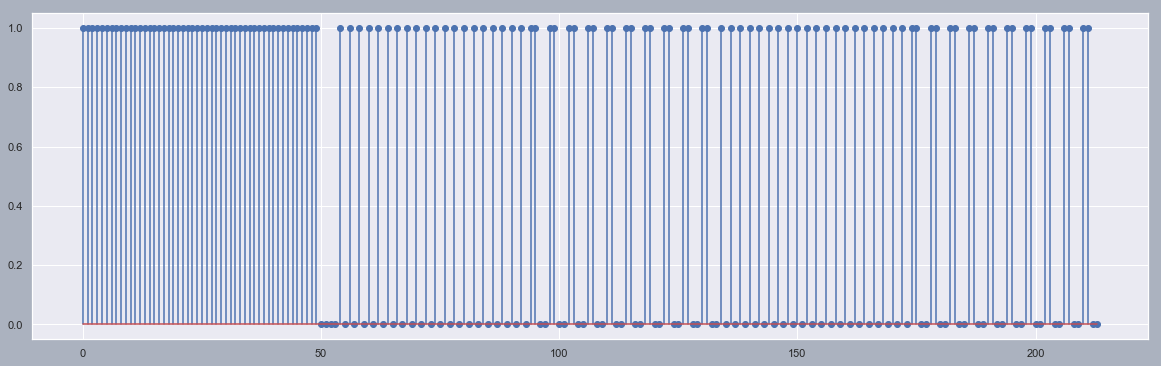

In [68]:
plot_subset(DP.discretized_array, 46, 260)

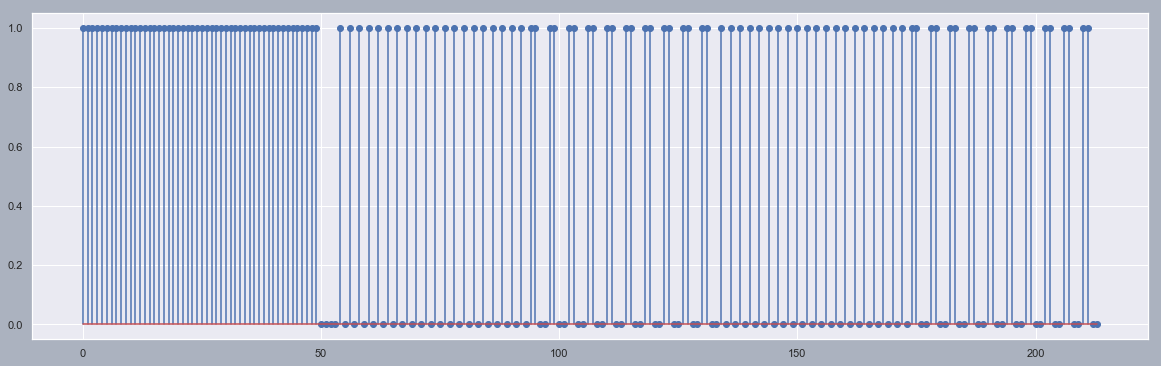

In [63]:
plot_subset(DP.discretized_array, 260, 260+214)

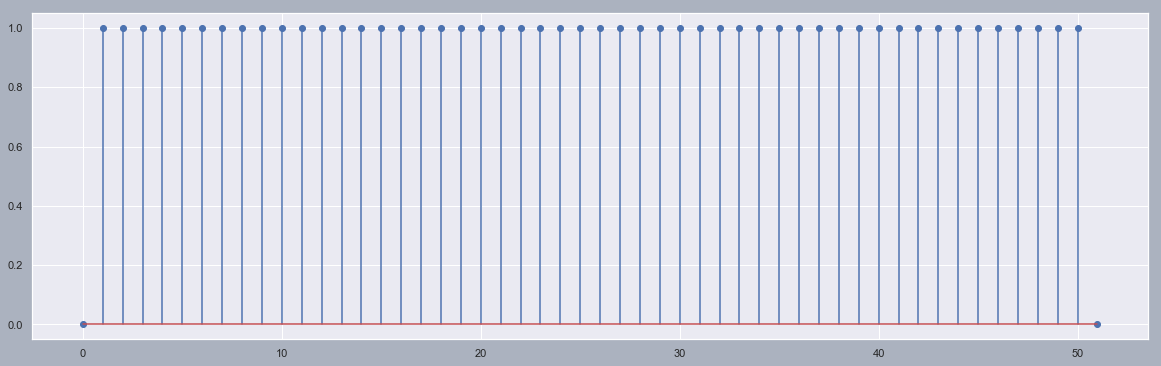

In [72]:
plot_subset(DP.discretized_array, 45, 97)

## visualization 

In [19]:
# seaborn with custom background
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid',rc={'figure.facecolor':'#abb2bf'})

### util functions

In [18]:
def plot_subset(data, start, stop):
    plt.figure(figsize=(20, 6))
    
    plt.stem(data[start:stop])

def compare_plots(start, stop, title):
    fig, ((ax1, ax2)) = plt.subplots(2, 1, sharex=False, sharey=True, figsize=(15,6))
    
    ax1.stem(DP.data[start*DP.spb:stop*DP.spb])
    ax2.stem(DP.discretized_array[start:stop]) 
    
    ax1.set_title(title)
    

### plots

In [ ]:
compare_plots(0, 25)

In [ ]:
compare_plots(150, 200)